<a href="https://colab.research.google.com/github/JorgeTabera/DataScienceII.CoderH/blob/main/Proyecto_Spotify_DS_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎶 Proyecto: Análisis de Playlists de Spotify

Este proyecto tiene como objetivo **extraer datos de playlists de Spotify** utilizando su API, para luego analizarlos y obtener insights sobre tendencias musicales en Argentina.  
El flujo de trabajo se estructura en pasos claros: **conexión, autenticación, extracción y exploración de datos**.

---
---

###  Preguntas de interés

A lo largo del análisis, se buscará responder las siguientes preguntas para entender mejor las tendencias musicales en Arg:

- 🎧 ¿Qué artistas dominan el Top 50 actual?
- 📈 ¿Qué géneros musicales son más frecuentes en la playlist?
- 🌍 ¿Qué proporción de artistas son locales vs. internacionales?
- 🔥 ¿Qué canciones tienen mayor popularidad y por qué?
- 🧠 ¿Existe relación entre la popularidad del artista y la del track?
- 📅 ¿Los lanzamientos recientes tienen mayor presencia en el ranking?
- 💃 ¿Qué tan bailables y energéticas son las canciones más populares?
- 🎶 ¿Qué géneros están asociados a mayor popularidad?
- 📊 ¿Qué insights se pueden extraer combinando popularidad, géneros y audio features?

Estas preguntas orientan el análisis exploratorio y permiten construir visualizaciones y conclusiones relevantes para audiencias técnicas y ejecutivas.




## 📌 Bloque 1: Importación de librerías

In [20]:
import os
from google.colab import drive
import requests, base64
import pandas as pd
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
#Estilo visual para graficos ↓
sns.set(style="whitegrid")


## 📌 Bloque 2: Montar Google Drive y leer credenciales

Para mantener las credenciales seguras, las guardamos en un archivo `.txt` dentro de Google Drive.  
Aquí montamos el Drive y accedemos al archivo que contiene el `CLIENT_ID` y `CLIENT_SECRET`, necesarios para generar el token de acceso.

> 📂 Ruta del archivo: `/MyDrive/CoderHouse/DataScienceII/SpotCredDSII.txt`


In [2]:
##Importamos Drive para trabajar con el Token de la API

drive.mount('/content/drive')

##Ingresamos al archivo que contiene las credenciales y lo importamos con variables:
cred_path = "/content/drive/MyDrive/CoderHouse/DataScienceII /SpotCredDSII.txt"

creds = {}
with open(cred_path) as f:
    for line in f:
        key, value = line.strip().split("=")
        creds[key] = value

CLIENT_ID = creds["CLIENT_ID"]
CLIENT_SECRET = creds["CLIENT_SECRET"]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📌 Bloque 3: Generar el token de acceso

Con las credenciales obtenidas, generamos el token de acceso mediante el flujo de `client_credentials`.  
Este token nos permite realizar consultas a la API de Spotify sin necesidad de autorización del usuario.

> 🔐 El token tiene una validez temporal y debe regenerarse en cada sesión.


In [3]:
## Ingresamos el token en la API

auth_str = f"{CLIENT_ID}:{CLIENT_SECRET}"
b64_auth = base64.b64encode(auth_str.encode()).decode()

headers = {
    "Authorization": f"Basic {b64_auth}",
    "Content-Type": "application/x-www-form-urlencoded"
}
data = {"grant_type": "client_credentials"}

try:
    r = requests.post("https://accounts.spotify.com/api/token", headers=headers, data=data)
    r.raise_for_status()
    TOKEN = r.json()["access_token"]
    print("✅ Conexión exitosa! Token generado:", TOKEN[:20], "...")
except Exception as e:
    print("❌ Verificar credenciales, no conectó")
    print("Error:", e)


✅ Conexión exitosa! Token generado: BQBUx4OOWwZNK5C44InN ...


## 📌 Bloque 4: Extracción de datos de la playlist

En este paso consultamos una playlist pública de Spotify y extraemos los primeros 50 tracks disponibles.  
Para cada canción obtenemos información clave como:

- 🎵 Nombre del track  
- 👥 Artistas participantes  
- 📈 Popularidad (score de 0 a 100)  
- 💿 Álbum al que pertenece  
- 📅 Fecha de lanzamiento del álbum  
- 🆔 ID único del track  
- 🔗 URI interno de Spotify  
- 🖼️ Imagen del álbum (carátula en alta resolución)

Toda esta información se organiza en una tabla con columnas ordenadas, lo que permite visualizar y analizar fácilmente los atributos principales de cada canción.

> 🎧 Playlist utilizada: `"El Top 50 de Argentina"`  
> 🌎 Mercado: `"AR"`  
> 🔢 Límite: `50 tracks`  

Este paso nos permite construir una base sólida para el análisis musical, incluyendo visualización de carátulas, comparación de popularidad y perfil de artistas.


In [4]:
playlist_id = "7HOoKCy3TmkweeT9SskCxq"
url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"

headers = {"Authorization": f"Bearer {TOKEN}"}
params = {"market": "AR", "limit": 50}

resp = requests.get(url, headers=headers, params=params)
resp.raise_for_status()
tracks = resp.json()


data = []
for idx, item in enumerate(tracks["items"], start=1):
    track = item["track"]
    artists = ", ".join(a["name"] for a in track["artists"])
    album_images = track["album"]["images"]
    image_url = album_images[0]["url"] if album_images else None  # la de mayor resolución


    data.append({
        "puesto": idx,
        "nombre": track["name"],
        "album": track["album"]["name"],
        "artistas": artists,
        "popularidad": track["popularity"],
        "id": track["id"],
        "uri": track["uri"],
        "imagen": image_url
    })

# Orden explícito de columnas
df_tracks = pd.DataFrame(data, columns=["puesto", "imagen","nombre", "artistas","album", "popularidad", "id", "uri"])


## 📌 Paso 5: Visualización de carátulas de los 10 primeros tracks

En este paso enriquecemos la tabla de canciones mostrando las **carátulas de los álbumes** directamente en el notebook.  
Esto permite una visualización más atractiva y facilita identificar cada track de manera visual.

- 🎵 Nombre del track  
- 👥 Artistas participantes  
- 💿 Álbum al que pertenece  
- 📈 Popularidad  
- 🖼️ Carátula del álbum renderizada como imagen  

Para mantener la notebook ordenada, limitamos la visualización a los **10 primeros puestos** del ranking.

> ✅ Resultado: listado con información textual y carátulas en tamaño uniforme.


In [5]:

for _, row in df_tracks.head(10).iterrows():
    print(f"{row['puesto']}. {row['nombre']} — {row['artistas']}")
    print(f"🎧 Álbum: {row['album']} | Popularidad: {row['popularidad']}")
    display(Image(url=row['imagen'], width=300))
    print("-" * 60)

1. Tu jardín con enanitos — Roze Oficial, Max Carra, Valen, RAMKY EN LOS CONTROLES
🎧 Álbum: Tu jardín con enanitos | Popularidad: 81


------------------------------------------------------------
2. Daddy Yankee: Bzrp Music Sessions, Vol. 0/66 — Bizarrap, Daddy Yankee
🎧 Álbum: Daddy Yankee: Bzrp Music Sessions, Vol. 0/66 | Popularidad: 89


------------------------------------------------------------
3. TU VAS SIN (fav) — Rels B
🎧 Álbum: afroLOVA 25' | Popularidad: 89


------------------------------------------------------------
4. Cuando No Era Cantante — El Bogueto, Yung Beef
🎧 Álbum: No Hay Loco Que No Corone | Popularidad: 88


------------------------------------------------------------
5. QLOO* — Young Cister, Kreamly
🎧 Álbum: QLOO* | Popularidad: 88


------------------------------------------------------------
6. La Perla — ROSALÍA, Yahritza Y Su Esencia
🎧 Álbum: LUX | Popularidad: 90


------------------------------------------------------------
7. YO y TÚ — Ovy On The Drums, Quevedo, Beéle
🎧 Álbum: YO y TÚ | Popularidad: 88


------------------------------------------------------------
8. SOLEAO — Myke Towers, Quevedo
🎧 Álbum: ISLAND BOYZ | Popularidad: 79


------------------------------------------------------------
9. HASTA QUE ME ENAMORO — Maria Becerra, TINI, XROSS
🎧 Álbum: QUIMERA | Popularidad: 49


------------------------------------------------------------
10. TODO KE VER — Jere Klein, Katteyes, Mateo on the Beatz
🎧 Álbum: TODO KE VER | Popularidad: 85


------------------------------------------------------------


## 📌 Bloque 6: Enriquecimiento con información de artistas y álbumes

En este bloque utilizamos los **IDs de artistas y álbumes** que ya obtuvimos en el Bloque 4 para consultar la API de Spotify y traer datos adicionales que enriquecen nuestro dataset.

### 🔎 Objetivos
- Obtener **géneros**, **seguidores** y **popularidad** de cada artista.
- Obtener **fecha de lanzamiento**, **sello discográfico** y **cantidad de tracks** de cada álbum.
- Unir esta información con el DataFrame base (`df_tracks`) para construir un dataset completo.

### 🛠️ Pasos principales
1. **Helper `chunks`**  
   - Función que divide listas en lotes de tamaño fijo (50 para artistas, 20 para álbumes).  
   - Esto es necesario porque la API tiene límites de IDs por request.

2. **Consulta de artistas (`/v1/artists`)**  
   - Se envían los IDs en lotes de hasta 50.  
   - Se obtiene un JSON con datos de cada artista.  
   - Se transforma en `df_artists` con columnas:
     - `artist_id`
     - `artist_name`
     - `genres`
     - `followers`
     - `artist_popularity`

3. **Consulta de álbumes (`/v1/albums`)**  
   - Se envían los IDs en lotes de hasta 20.  
   - Se obtiene un JSON con datos de cada álbum.  
   - Se transforma en `df_albums` con columnas:
     - `album_id`
     - `album_name`
     - `release_date`
     - `total_tracks`
     - `label`

4. **Unión final (`merge`)**  
   - Se une `df_tracks` con `df_albums` por nombre de álbum.  
   - Se une `df_tracks` con `df_artists` usando el primer artista principal.  
   - Resultado: `df_final`, un DataFrame enriquecido con información de **tracks + artistas + álbumes**.

### 📦 Resultado esperado
Un dataset con columnas como:
- Información básica: `puesto`, `nombre`, `artistas`, `album`, `popularidad`, `imagen`, `id`, `uri`
- Info de álbum: `release_date`, `total_tracks`, `label`
- Info de artista: `genres`, `followers`, `artist_popularity`

Este dataset completo permite realizar análisis más avanzados:
- Distribución de géneros en el Top 50.  
- Relación entre popularidad y seguidores.  
- Comparación entre tracks recientes y antiguos.  


In [24]:
# --- Helper para dividir en lotes ---
def chunks(lst, n=50):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

# --- 6. Enriquecer con info de artistas ---
all_artists = []
url_artists = "https://api.spotify.com/v1/artists"

for batch in chunks(list(set(artist_ids)), 50):
    resp_artists = requests.get(url_artists, headers=headers, params={"ids": ",".join(batch)})
    resp_artists.raise_for_status()
    all_artists.extend(resp_artists.json()["artists"])

df_artists = pd.DataFrame([{
    "artist_id": a["id"],
    "artist_name": a["name"],
    "genres": ", ".join(a.get("genres", [])),
    "followers": a["followers"]["total"],
    "artist_popularity": a["popularity"]
} for a in all_artists])

# --- 7. Enriquecer con info de álbumes ---
all_albums = []
url_albums = "https://api.spotify.com/v1/albums"

for batch in chunks(list(set(album_ids)), 20):  # límite 20 por request
    resp_albums = requests.get(url_albums, headers=headers, params={"ids": ",".join(batch)})
    resp_albums.raise_for_status()
    all_albums.extend(resp_albums.json()["albums"])

df_albums = pd.DataFrame([{
    "album_id": alb["id"],
    "album_name": alb["name"],
    "release_date": alb["release_date"],
    "total_tracks": alb["total_tracks"],
    "label": alb.get("label", "")
} for alb in all_albums])

# --- 8. Unión final optimizada ---
df_final = df_tracks.merge(
    df_albums[["album_id","album_name","release_date","total_tracks","label"]],
    left_on="album", right_on="album_name", how="left"
)

# Crear columna con el artista principal
df_final["Artista_Princ"] = df_final["artistas"].str.split(",").str[0]

df_final = df_final.merge(
    df_artists[["artist_id","artist_name","genres","followers","artist_popularity"]],
    left_on="Artista_Princ", right_on="artist_name", how="left"
)

# Selección final de columnas para insights (incluyendo Artista_Princ debajo de artistas)
df_final = df_final[[
    "puesto",          # ranking en la playlist
    "nombre",          # nombre del track
    "artistas",        # artistas participantes
    "Artista_Princ",   # artista principal
    "album",           # nombre del álbum
    "popularidad",     # popularidad del track
    "release_date",    # fecha de lanzamiento del álbum
    "genres",          # géneros del artista principal
    "followers",       # seguidores del artista principal
    "artist_popularity" # popularidad del artista principal
]]

df_final.head(10)


,puesto,nombre,artistas,Artista_Princ,album,popularidad,release_date,genres,followers,artist_popularity
0,1,Tu jardín con enanitos,"Roze Oficial, Max Carra, Valen, RAMKY EN LOS C...",Roze Oficial,Tu jardín con enanitos,81,2025-05-22,"rkt, turreo, cumbia, cuarteto",229313,66
1,2,"Daddy Yankee: Bzrp Music Sessions, Vol. 0/66","Bizarrap, Daddy Yankee",Bizarrap,"Daddy Yankee: Bzrp Music Sessions, Vol. 0/66",89,2025-11-05,"argentine trap, trap latino, urbano latino",18290737,81
2,3,TU VAS SIN (fav),Rels B,Rels B,afroLOVA 25',89,2025-06-20,"urbano latino, trap latino",10052655,82
3,4,Cuando No Era Cantante,"El Bogueto, Yung Beef",El Bogueto,No Hay Loco Que No Corone,88,2024-09-26,"reggaeton mexa, reggaeton",1439194,76
4,5,QLOO*,"Young Cister, Kreamly",Young Cister,QLOO*,88,2025-05-22,"chilean trap, reggaeton chileno, chilean mambo",772574,74
5,6,La Perla,"ROSALÍA, Yahritza Y Su Esencia",ROSALÍA,LUX,90,2025-11-07,latin,8929991,88
6,7,YO y TÚ,"Ovy On The Drums, Quevedo, Beéle",Ovy On The Drums,YO y TÚ,88,2025-06-11,reggaeton,1490073,83
7,8,SOLEAO,"Myke Towers, Quevedo",Myke Towers,ISLAND BOYZ,79,2025-07-17,"reggaeton, trap latino, urbano latino",22179478,86
8,9,HASTA QUE ME ENAMORO,"Maria Becerra, TINI, XROSS",Maria Becerra,QUIMERA,49,2025-11-20,argentine trap,8312043,77
9,10,TODO KE VER,"Jere Klein, Katteyes, Mateo on the Beatz",Jere Klein,TODO KE VER,85,2025-08-13,"reggaeton chileno, chilean mambo, chilean trap...",3251552,77


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


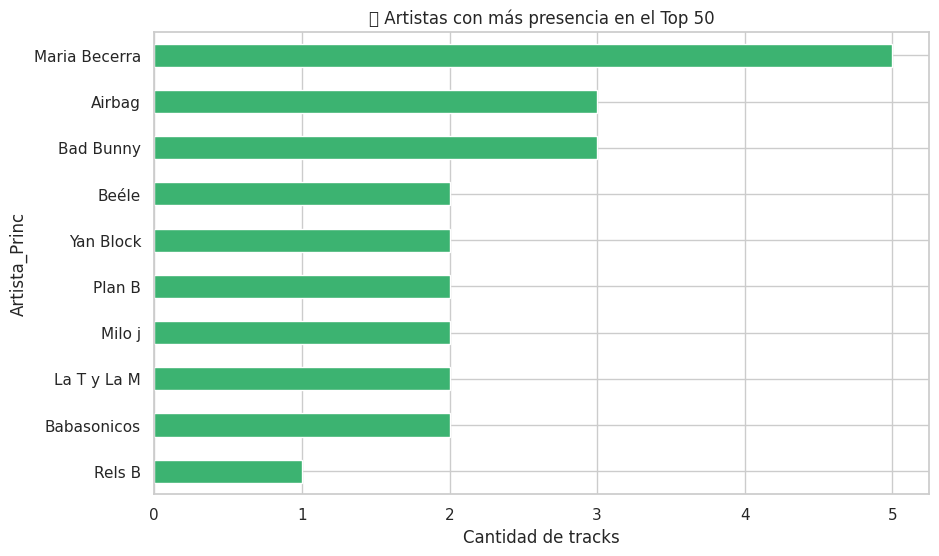

In [26]:

top_artistas = df_final["Artista_Princ"].value_counts().head(10)
top_artistas.plot(kind="barh", figsize=(10,6), color="mediumseagreen")
plt.title("🎤 Artistas con más presencia en el Top 50")
plt.xlabel("Cantidad de tracks")
plt.gca().invert_yaxis()
plt.show()
